In [2230]:
from importlib import reload
import static_model
reload(static_model)
from static_model import *

In [2231]:
import networkx as nx
import numpy as np
import torch

In [ ]:
import wntr
import pandas as pd
import numpy as np

n_samples = 10

inp_file = 'network_file.inp'

# Fixed discharge coefficient for turbulent leaks
Cd = 0.75  

A_max = 0.05
# Leak areas from no leak to large leak
leak_ratio = np.linspace(0, A_max, n_samples)
leak_areas = 3.14159*(leak_ratio/2)**2

# This should match your reservoir pipe ID
reservoir_pipe_id = 'RESERVOIR'  # <-- change to your actual reservoir pipe name

results_list = []
flow_list = []

for area in leak_areas:
    emitter_coeff = Cd * np.sqrt(area)
    
    wn = wntr.network.WaterNetworkModel(inp_file)
    junction = wn.get_node('JUNCTION-0')
    junction.add_leak(wn, area=area, discharge_coeff=0.75, start_time=0)
    

    sim = wntr.sim.WNTRSimulator(wn)
    results = sim.run_sim()

    pressure = results.node['pressure'].iloc[0]
    flow = results.link['flowrate'].iloc[0]
        
    
    #print(f"Leak Area: {area:.5f} m² --> Pressure: {pressure['JUNCTION-0']:.2f} m")

    # Store only the pressure at JUNCTION-0
    pressure_df = pd.DataFrame({
        'Leak Area (m²)': [area],
        'Pressure at JUNCTION-0 (m)': [pressure['JUNCTION-0']]
    })
    results_list.append(pressure_df)
    # Store only the flow through the reservoir pipe
    flow_df = pd.DataFrame({
        'Leak Area (m²)': [area],
        'Flowrate at Reservoir (m³/s)': flow.values
    })
    flow_list.append(flow_df)

# Combine results
pressures = pd.concat(results_list, ignore_index=True)
flows = pd.concat(flow_list, ignore_index=True)

display(pressures)
display(flows)


,Leak Area (m²),Pressure at JUNCTION-0 (m)
0,0.000000,49.990143
1,0.000491,49.985525
2,0.001963,49.966939


,Leak Area (m²),Flowrate at Reservoir (m³/s)
0,0.000000,0.050000
1,0.000491,0.061529
2,0.001963,0.096109


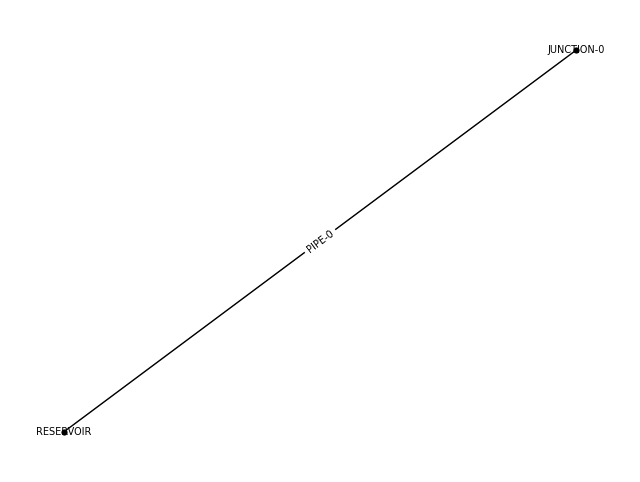

In [2233]:
from wntr.graphics import plot_network
import matplotlib.pyplot as plt

# Plot just the structure of the network
fig, ax = plt.subplots(figsize=(8, 6))
plot_network(wn, node_labels=True, link_labels=True, ax=ax)
plt.show()

In [2234]:
G = wn.to_graph()
A = nx.incidence_matrix(G)
reservoirs = list(wn.reservoir_name_list)
# Get all node names (junctions, tanks, reservoirs)
all_nodes = list(G.nodes())

# Filter out reservoirs
non_reservoir_nodes = [n for n in all_nodes if n not in reservoirs]

idx = [i for i, n in enumerate(all_nodes) if n not in reservoirs]

# Get adjacency matrix using filtered nodelist
A  = nx.incidence_matrix(G)
A0 = torch.tensor(A[idx,:].toarray(), dtype=torch.float32)



In [2235]:
from scipy.sparse import dok_matrix

edgelist = list(G.edges())
supply_nodes = wn.reservoir_name_list  # or include tanks if needed
supply_nodes = list(supply_nodes)  # Ensure it's ordered

# Create edge-to-start-node mapping
edge_start_nodes = [edge[0] for edge in edgelist]

# Create B matrix (|E| x |supply_nodes|), sparse
B = dok_matrix((len(edgelist), len(supply_nodes)), dtype=int)

for i, (start_node) in enumerate(edge_start_nodes):
    if start_node in supply_nodes:
        j = supply_nodes.index(start_node)
        B[i, j] = 1

# Convert to CSR format for efficient arithmetic
B = torch.tensor(B.toarray(), dtype=torch.float32)

In [2236]:
junctions = wn.junction_name_list  # Only junctions have demand

# Get base demands at each junction
D_values = []
for name in junctions:
    junction = wn.get_node(name)
    demand = junction.base_demand  # in m³/s
    D_values.append(demand)

# D is a NumPy array aligned with junction_name_list
D = torch.tensor(D_values, dtype=torch.float32)
print(D)

tensor([0.0500])


In [2237]:
# Get supply node names
supply_nodes = wn.reservoir_name_list  # Or include tanks if needed

# Get heads at each supply node
S_values = []
for name in supply_nodes:
    reservoir = wn.get_node(name)
    head = reservoir.base_head  # This is constant in steady state
    S_values.append(head)

S = torch.tensor(S_values, dtype=torch.float32)
print(S)


tensor([50.])


In [2238]:
pipe_names = wn.pipe_name_list  # List of all pipe IDs

# Get length of each pipe (in meters)
L = torch.tensor([wn.get_link(name).length for name in pipe_names], dtype=torch.float32)

# Get diameter of each pipe (in meters)
d = torch.tensor([wn.get_link(name).diameter for name in pipe_names], dtype=torch.float32)

# Get Hazen-Williams roughness coefficients (unitless)
C = torch.tensor([wn.get_link(name).roughness for name in pipe_names], dtype=torch.float32)

print(C)

tensor([100.])


In [2239]:
model_params = {
    'A0': A0,
    'B' : B,
    'A_max' : leak_areas.max(),
    'S' : S,
    'D' : D,
    'd': d,
    'L': L,
    'Cd' : 0.75, 
    'C' : C,
    'rho' : 1000.0,
    'n_samples' : 10
}

net_params = {
        'depth' : 3,
        'layer_sizes' : [42,42,42,1], 
        'activation' : 'relu',
}


In [2240]:
model = Model(model_params, net_params)
model.train(iterations=100000, print_interval=1000)

step       loss       e1          e2
1000       1.40e-02   2.17e-03   1.18e-02        New Best!
2000       5.95e-03   2.09e-03   3.86e-03        New Best!
3000       3.48e-03   2.14e-03   1.34e-03        New Best!
4000       2.39e-01   1.73e-01   6.58e-02        
5000       2.24e-03   2.19e-03   4.98e-05        New Best!
6000       2.21e-03   2.20e-03   1.37e-05        New Best!
7000       2.21e-03   2.21e-03   1.93e-06        New Best!
8000       2.21e-03   2.21e-03   1.42e-06        New Best!
9000       2.21e-03   2.21e-03   1.64e-06        
10000      2.21e-03   2.21e-03   1.65e-06        
11000      7.33e-02   1.63e-03   7.16e-02        
12000      2.26e-03   2.19e-03   6.96e-05        
13000      2.21e-03   2.20e-03   1.03e-05        
14000      2.21e-03   2.20e-03   9.13e-06        
15000      2.21e-03   2.20e-03   7.63e-06        
16000      2.21e-03   2.20e-03   6.76e-06        
17000      2.21e-03   2.20e-03   4.54e-06        
18000      2.21e-03   2.20e-03   3.85e-06        


KeyboardInterrupt: 

In [2241]:
import torch

# Step 1: Prepare input tensor from leak areas
A = torch.tensor(leak_areas, dtype=torch.float32).reshape(-1, 1)

# Step 2: Predict pressure and flow using the trained model
H, q = model.net(A)  # Predicted pressure at JUNCTION-0
H = H.detach().flatten()
q = q.detach().flatten()

# Step 3: Append predicted values to the dataframes

# Append to `final_results` (pressure data)
pressures['Predicted Pressure at JUNCTION-0 (m)'] = H
pressures['Pressure Error (m)'] = pressures['Predicted Pressure at JUNCTION-0 (m)'] - pressures['Pressure at JUNCTION-0 (m)']

# Append to `pipe_flows` (flowrate data)
flows['Predicted Flowrate at Reservoir (m³/s)'] = q
flows['Flowrate Error (m³/s)'] = flows['Predicted Flowrate at Reservoir (m³/s)'] - flows['Flowrate at Reservoir (m³/s)']

# Display updated tables
print("\n=== Final Results (Pressures) with Predictions ===")
display(pressures)

print("\n=== Pipe Flows (Reservoir) with Predictions ===")
display(flows)



=== Final Results (Pressures) with Predictions ===


,Leak Area (m²),Pressure at JUNCTION-0 (m),Predicted Pressure at JUNCTION-0 (m),Pressure Error (m)
0,0.000000,49.990143,49.985397,-0.004746
1,0.000491,49.985525,49.958931,-0.026594
2,0.001963,49.966939,49.879490,-0.087449



=== Pipe Flows (Reservoir) with Predictions ===


,Leak Area (m²),Flowrate at Reservoir (m³/s),Predicted Flowrate at Reservoir (m³/s),Flowrate Error (m³/s)
0,0.000000,0.050000,0.057369,0.007369
1,0.000491,0.061529,0.057364,-0.004165
2,0.001963,0.096109,0.057337,-0.038771


torch.Size([10])
torch.Size([10, 1])


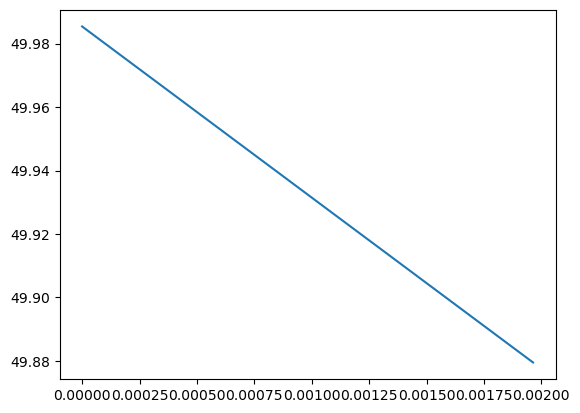

In [2244]:
A = torch.linspace(0, leak_areas.max(), 10).reshape(-1, 1)
H, q = model.net(A)  # Predicted pressure at JUNCTION-0
H = H.detach().flatten()
q = q.detach().flatten()

A = A.detach()

print(H.shape)
print(A.shape)

plt.plot(A, H)
plt.show()

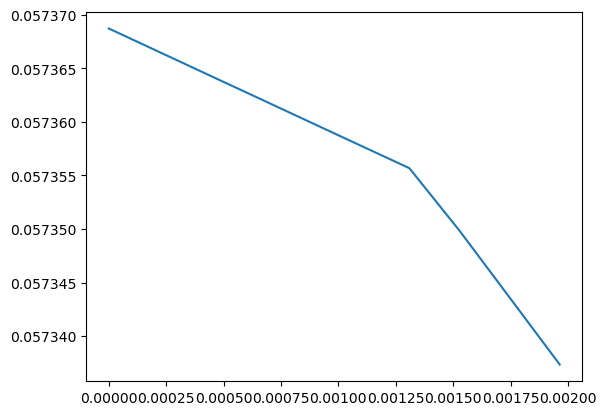

In [2245]:
plt.plot(A, q)
plt.show()